# Step 1: Exploratory Data Analysis (EDA)

This initial phase focuses on understanding the APTOS 2019 dataset. We will:
1. Load the training labels.
2. Visualize a sample image from each of the five diagnostic classes.
3. Plot the distribution of the classes to check for imbalance.

This exploration is critical as it informs our preprocessing strategy. The significant class imbalance observed will necessitate a **stratified** train-validation split to ensure the model sees a representative distribution of classes during both training and evaluation. Dataset from [Kaggle](https://www.kaggle.com/c/aptos2019-blindness-detection/overview)

In [6]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Add our custom source code to the path
sys.path.append("../src")  
# Import our custom functions
from data_setup import get_data_splits, create_dataloaders

# Load the main dataset labels
df_train = pd.read_csv('../data/raw/aptos2019-blindness-detection/train.csv')

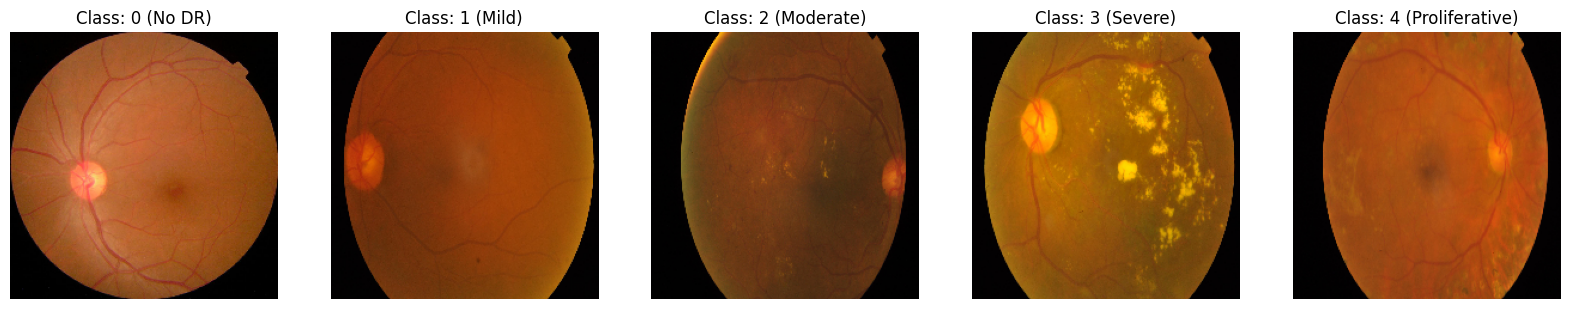

In [7]:
train_image_dir = '../data/raw/aptos2019-blindness-detection/train_images/'

class_labels = {
    0: 'No DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferative'
}

plt.figure(figsize=(20, 10))

for i in range(5):
    # Find the first image for the current class
    sample_id = df_train[df_train['diagnosis'] == i].iloc[0]['id_code']
    image_path = os.path.join(train_image_dir, f"{sample_id}.png")
    
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert for matplotlib
    img = cv2.resize(img, (224, 224)) # Resize for consistent display
    
    # Display the image
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Class: {i} ({class_labels[i]})")
    plt.axis('off')
    
plt.show()

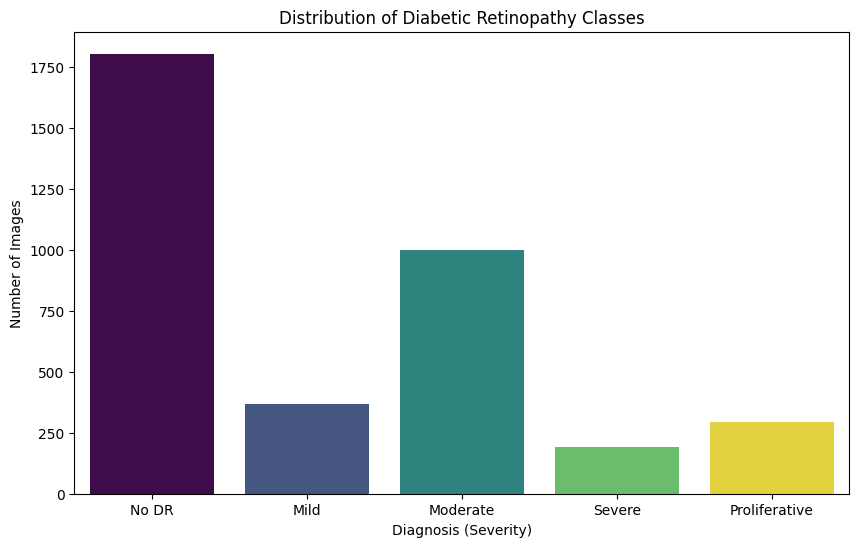

In [8]:
class_counts = df_train['diagnosis'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(10, 6))

sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis", hue=class_counts.index, legend=False)

plt.title('Distribution of Diabetic Retinopathy Classes')
plt.xlabel('Diagnosis (Severity)')
plt.ylabel('Number of Images')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'])
plt.show()

# Step 2: Data Preparation

This section implements **Section 3.1 (Dataset and Preprocessing)** of the research proposal. We delegate the logic to our `data_setup.py` module to keep this notebook clean.

### 2.1: Splitting and Caching the Data

We first split the data into stratified 80/20 training and validation sets. To save time on future runs, our custom `get_data_splits` function will automatically save the resulting dataframes to `train_split.csv` and `val_split.csv` in the `../data/processed` directory. If these files already exist, the function will load them directly, skipping the split process.

In [9]:
# Define paths for our data
raw_data_dir = '../data/raw/aptos2019-blindness-detection/'
processed_data_dir = '../data/processed/'
train_image_dir = os.path.join(raw_data_dir, 'train_images/')

# Create the processed data directory if it doesn't exist
os.makedirs(processed_data_dir, exist_ok=True)

# Get the train/validation splits (from cache or by creating them)
train_df, val_df = get_data_splits(df_train, processed_data_dir)

print(f"\nTraining set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print("\nValidation set distribution:\n", val_df['diagnosis'].value_counts(normalize=True).sort_index())

Loading cached data splits...

Training set size: 2929
Validation set size: 733

Validation set distribution:
 diagnosis
0    0.492497
1    0.100955
2    0.272851
3    0.053206
4    0.080491
Name: proportion, dtype: float64


### 2.2: Creating the DataLoaders

Now that we have our dataframes, we use our `create_dataloaders` helper function. This function handles all the PyTorch-specific boilerplate:
-   Applying the correct transformations and data augmentation.
-   Wrapping the dataframes in a custom `Dataset` class.
-   Setting up the `DataLoader` to efficiently serve batches of data to the model.

In [10]:
# --- Create the DataLoaders ---
BATCH_SIZE = 32
train_loader, val_loader = create_dataloaders(
    train_df=train_df,
    val_df=val_df,
    image_dir=train_image_dir,
    batch_size=BATCH_SIZE,
    num_workers= 1
)

# Verify that the dataloader is working correctly
images, labels = next(iter(train_loader))
print(f"\nShape of a batch of images: {images.shape}")
print(f"Shape of a batch of labels: {labels.shape}")
print(f"Data type of images: {images.dtype}")


Shape of a batch of images: torch.Size([32, 3, 224, 224])
Shape of a batch of labels: torch.Size([32])
Data type of images: torch.float32


# Step 3: Model Architecture and Training

This section implements **Section 3.2** of the research proposal. We will:
1.  Define a `DRClassifier` class using PyTorch Lightning. This class encapsulates the ResNet50 model, the training logic, validation logic, and optimizer configuration.
2.  Instantiate and train **Model A (Transfer Learning)**, where only the final classification layer is trained.
3.  Instantiate and train **Model B (Fine-Tuning)**, where all layers are unfrozen and trained with a low learning rate.

In [11]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import Accuracy

In [12]:
class DRClassifier(pl.LightningModule):
    def __init__(self, num_classes=5, learning_rate=1e-3, unfreeze_base=False):
        super().__init__()
        self.save_hyperparameters() # Saves args to self.hparams

        # Load the pretrained ResNet50 model
        self.model = models.resnet50(weights='IMAGENET1K_V2')

        # Freeze the convolutional base if specified (for Model A)
        if not unfreeze_base:
            for param in self.model.parameters():
                param.requires_grad = False

        # Replace the final fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        # Define loss and metrics
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits, y)
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits, y)

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        # The optimizer will only update the parameters that have requires_grad=True
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

### 3.1: Training Model A (Transfer Learning)

Here, we train the first model where the ResNet50 base is frozen. We are only training the weights of the new classification head. We'll use a `ModelCheckpoint` callback to automatically save the version of the model that achieves the best validation accuracy.

In [ ]:
# --- Configuration for Model A ---
LEARNING_RATE_A = 1e-3
MODEL_A_PATH = '../models/model_a_transfer_learning.ckpt'

# --- Setup Model A ---
model_a = DRClassifier(
    num_classes=5,
    learning_rate=LEARNING_RATE_A,
    unfreeze_base=False 
)

# --- Setup Callbacks ---
checkpoint_callback_a = ModelCheckpoint(
    monitor='val_acc',
    dirpath='../models/',
    filename='model_a_best',
    save_top_k=1,
    mode='max'
)

# --- Setup Trainer for Model A ---
trainer_a = pl.Trainer(
    max_epochs=10, 
    accelerator='auto', # Automatically uses GPU/MPS if available
    callbacks=[checkpoint_callback_a],
    logger=pl.loggers.TensorBoardLogger('../logs/', name='model_a')
)

# --- Start Training ---
trainer_a.fit(model_a, train_loader, val_loader)

### 3.2: Training Model B (Fine-Tuning)

Now, we train the second model where the entire network is unfrozen. As specified in the proposal, we use a much lower learning rate to prevent the pre-trained weights from being corrupted by large gradient updates.

In [ ]:
# --- Configuration for Model B ---
LEARNING_RATE_B = 1e-5 # Lower learning rate for fine-tuning
MODEL_B_PATH = '../models/model_b_fine_tuned.ckpt'

# --- Setup Model B ---
model_b = DRClassifier(
    num_classes=5,
    learning_rate=LEARNING_RATE_B,
    unfreeze_base=True # Unfreeze the entire network
)

# --- Setup Callbacks ---
checkpoint_callback_b = ModelCheckpoint(
    monitor='val_acc',
    dirpath='../models/',
    filename='model_b_best',
    save_top_k=1,
    mode='max'
)

# --- Setup Trainer for Model B ---
trainer_b = pl.Trainer(
    max_epochs=15, # May need more epochs for fine-tuning
    accelerator='auto',
    callbacks=[checkpoint_callback_b],
    logger=pl.loggers.TensorBoardLogger('../logs/', name='model_b')
)

# --- Start Training ---
trainer_b.fit(model_b, train_loader, val_loader)